Post simulation checks

# Import modules
import numpy as np
import zarr
import allel   
#idk why but my allel doesnt seem to load?? even though ive definitely installed it as scikit-allel
import scipy.cluster.hierarchy as sch
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal
from scipy.ndimage import gaussian_filter1d
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm
import dask
from dask.delayed import delayed
from dask.base import compute
from itertools import combinations
import time
import seaborn as sns
import sys
import tskit

1. import in vcf/ tree file to examine population size


In [4]:
# checking .tree outputs
import tskit
#tskit.load(file="C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/burnin_no.19_early.trees")
tree = tskit.load(file="C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/burnin_no.19_complete.trees")
print(tree)
tree.max_root_time()

# install pyslim !!! issue here involving msprime? pyslim cannot be imported/downloaded
#import pyslim

# read into pyslim and calculate nucleotide diversity and compare against expected nucleotide diversity (theta)
# check that it exceeds 10% and not more than 20%


╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │    10001║
╟───────────────┼─────────╢
║Sequence Length│    10001║
╟───────────────┼─────────╢
║Time Units     │    ticks║
╟───────────────┼─────────╢
║Sample Nodes   │    20000║
╟───────────────┼─────────╢
║Total Size     │154.9 MiB║
╚═══════════════╧═════════╝
╔═══════════╤═══════╤═════════╤════════════╗
║Table      │Rows   │Size     │Has Metadata║
╠═══════════╪═══════╪═════════╪════════════╣
║Edges      │2449938│ 74.8 MiB│          No║
╟───────────┼───────┼─────────┼────────────╢
║Individuals│  10000│978.4 KiB│         Yes║
╟───────────┼───────┼─────────┼────────────╢
║Migrations │      0│  8 Bytes│          No║
╟───────────┼───────┼─────────┼────────────╢
║Mutations  │ 792448│ 46.8 MiB│         Yes║
╟───────────┼───────┼─────────┼────────────╢
║Nodes      │ 370435│ 13.4 MiB│         Yes║
╟───────────┼───────┼─────────┼────────────╢
║Populations│      1│  2.3 KiB│         Yes║
╟─────

5000.0

2. Plot nucleotide diversity for all simulations.
- red flag if nucleotide diversity smaller than 10% or greater than 20%
- a. confidence intervals!
- make vector or csv with nucleotide diversity metric

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys 

#parameters = pd.read_csv('C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/Estimating-effective-population-size-from-resistance-loci/simulations/parameter_combinations.csv')
#print(parameters)
#how to loop through and calculate for each combination?
seed = 1811758731

def plot_burnin(seed):
    '''
    This function plots the heterozygosity from all burnin logfiles.csv
    
    Arguments:
        array_index : combination number of this simulation (1-27)
        seed: seed number of simulation
        
    Returns:
        figure: plot of heterozygosity against tick with baseline and upperlimit for reference
        

    ''' 
    #plot size etc
    plt.rcParams["figure.figsize"] = [15, 5]
    plt.rcParams["figure.autolayout"] = True

    # read in csv of parameter combinations and nucleotide diversity
    parameters = pd.read_csv('C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/Estimating-effective-population-size-from-resistance-loci/simulations/parameter_combinations.csv')
    
    for array_index in range(1, 28): 
        index = array_index + 1
        #baseline and upperlimit
        baseline = parameters.iloc[index]['baseline']
        upperlimit = parameters.iloc[index]['upperlimit']
        print("baseline:" + str(baseline))
        print("upperlimit:"+ str(upperlimit))
        #parameters
        N = parameters.iloc[index]['N']
        mu = parameters.iloc[index]['Mutation Rate']
        r = parameters.iloc[index]['Recombination Rate']
        subtitle = "N= "+ str(N)+", mu= "+ str(mu)+ ", r= " + str(r) + ", seed = " + str(seed)
        title = "Combination: " + str (array_index)

        #seeds
        # read in logfile.csv (interval=100ticks) 
        logfile_path = "burnin" + str(array_index) +"_logfile.csv"
        df = pd.read_csv(logfile_path)
        print(df) #debug point

        # plot 
        figure = plt.figure(array_index)
        plt.plot('cycle','Heterozygosity', data = df, figure=figure)
        plt.axhline(y=baseline, color='r', linestyle='-', figure=figure, ls='--', label='π+10%' ) #10% of nucleotide diversity for reference
        plt.axhline(y=upperlimit, color='r', linestyle='-', figure=figure, label='π+20%') #20% of nuc diversity for reference
        plt.xlabel('Generation', figure=figure)
        plt.ylabel('Heterozygosity (L)', figure=figure)
        plt.suptitle(title, figure=figure, fontsize =18)
        plt.title(subtitle, fontsize=14)
        plt.legend() # shows the axhline labels
        
        plt.show()
    return figure


baseline:0.091666667
upperlimit:0.1
    cycle  Heterozygosity
0       1        0.000499
1     101        0.038045
2     201        0.060149
3     301        0.072500
4     401        0.081562
5     501        0.085722
6     601        0.089579
7     701        0.088863
8     801        0.091146
9     901        0.089053
10   1001        0.090564


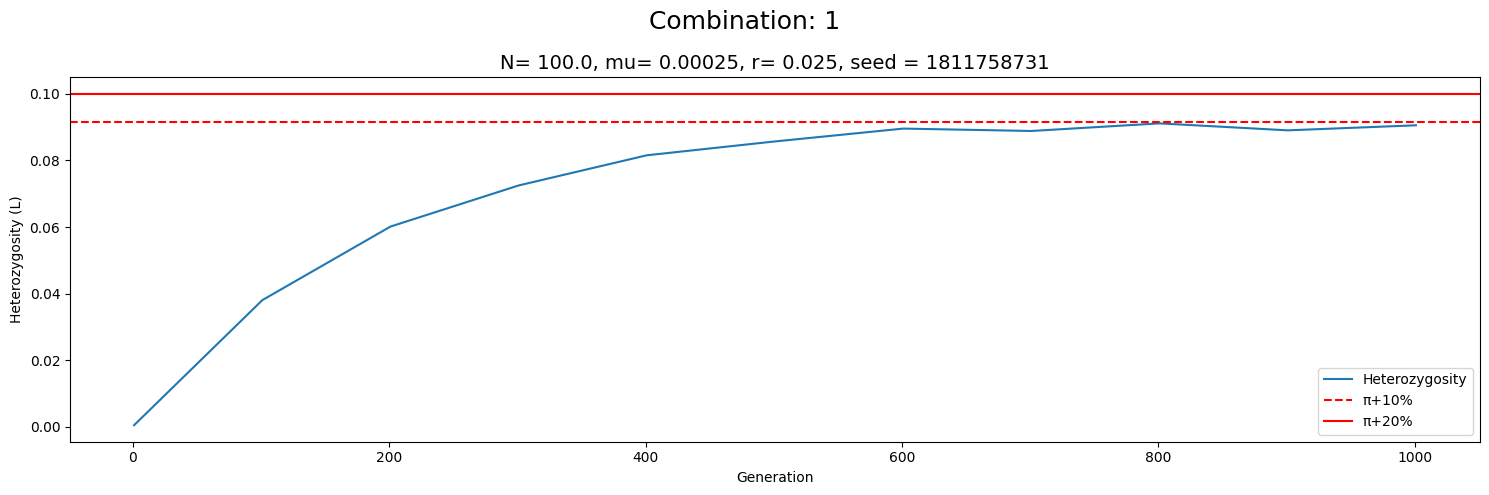

baseline:0.366666667
upperlimit:0.4
    cycle  Heterozygosity
0       1        0.000493
1     101        0.039184
2     201        0.061650
3     301        0.073832
4     401        0.081560
5     501        0.084081
6     601        0.087317
7     701        0.086430
8     801        0.090250
9     901        0.089945
10   1001        0.088627
11   1101        0.089003
12   1201        0.091135
13   1301        0.091276
14   1401        0.090187
15   1501        0.090462
16   1601        0.089764
17   1701        0.090600
18   1801        0.090690
19   1901        0.092109


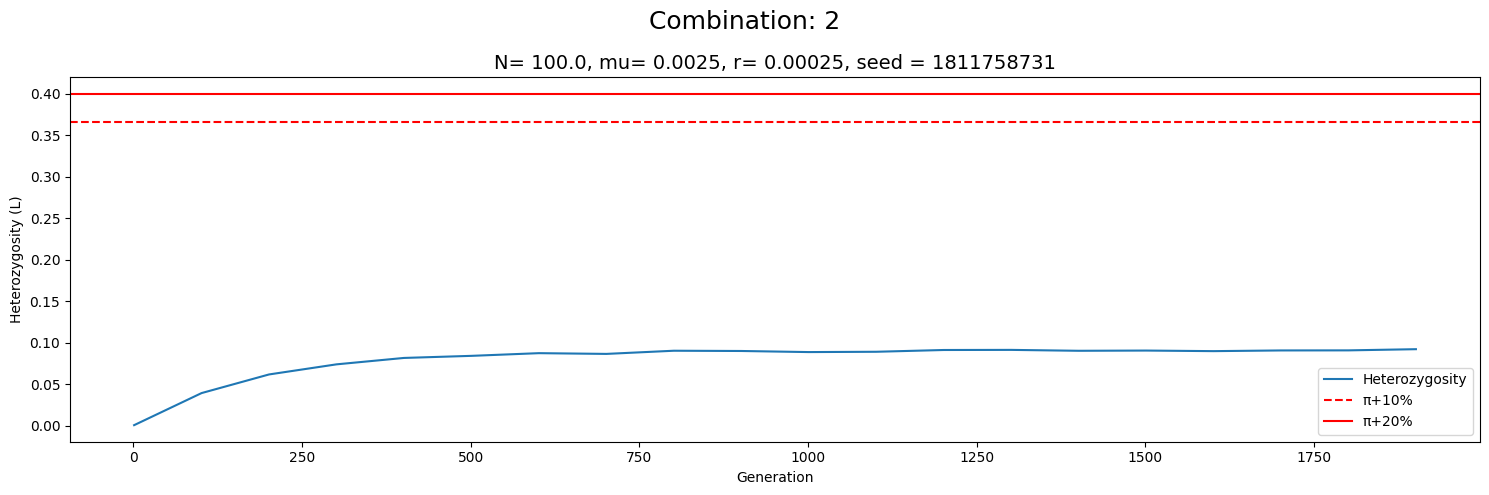

baseline:0.366666667
upperlimit:0.4
    cycle  Heterozygosity
0       1        0.000519
1     101        0.039480
2     201        0.063037
3     301        0.073335
4     401        0.080128
5     501        0.086463
6     601        0.087073
7     701        0.089354
8     801        0.089940
9     901        0.089971
10   1001        0.090956
11   1101        0.089777
12   1201        0.089736
13   1301        0.091056
14   1401        0.090585
15   1501        0.089262
16   1601        0.091647
17   1701        0.090646
18   1801        0.090830


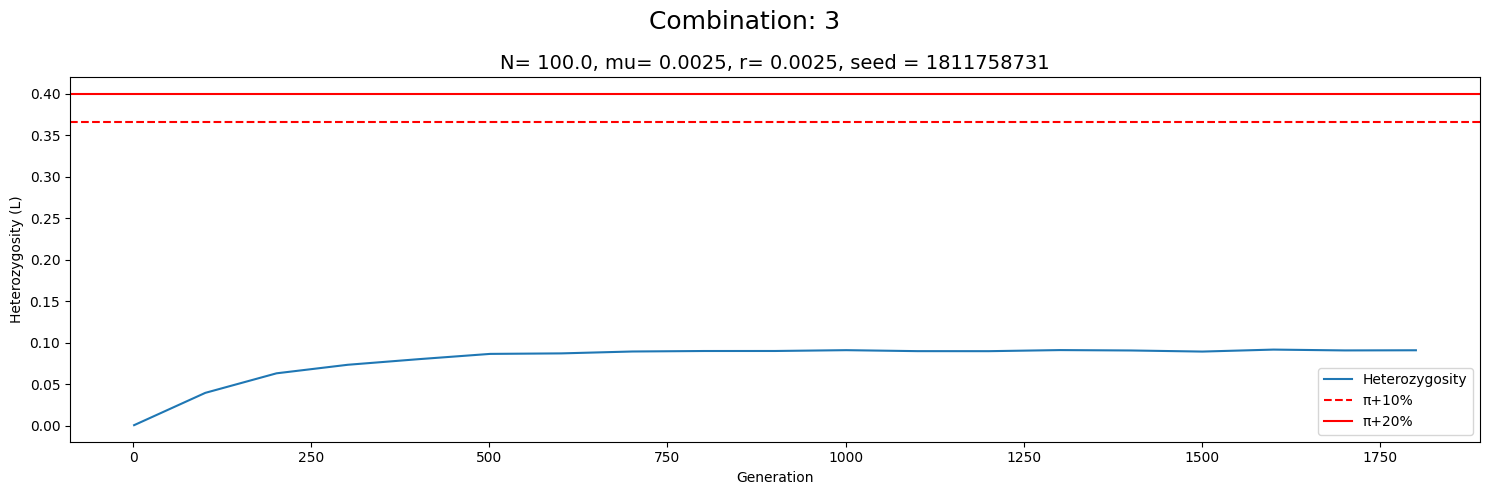

baseline:0.366666667
upperlimit:0.4
   cycle  Heterozygosity
0      1        0.004992
1    101        0.322321
2    201        0.433410
3    301        0.475636
4    401        0.487162


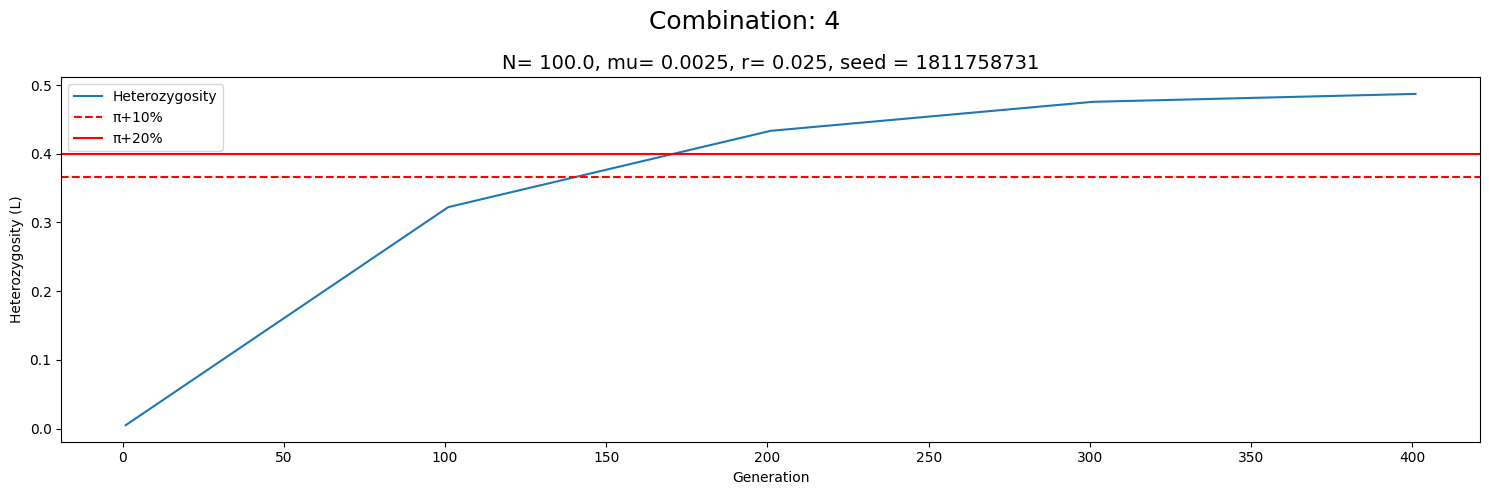

baseline:0.523809524
upperlimit:0.571428571
   cycle  Heterozygosity
0      1        0.005008
1    101        0.318786
2    201        0.436159
3    301        0.473607
4    401        0.488425


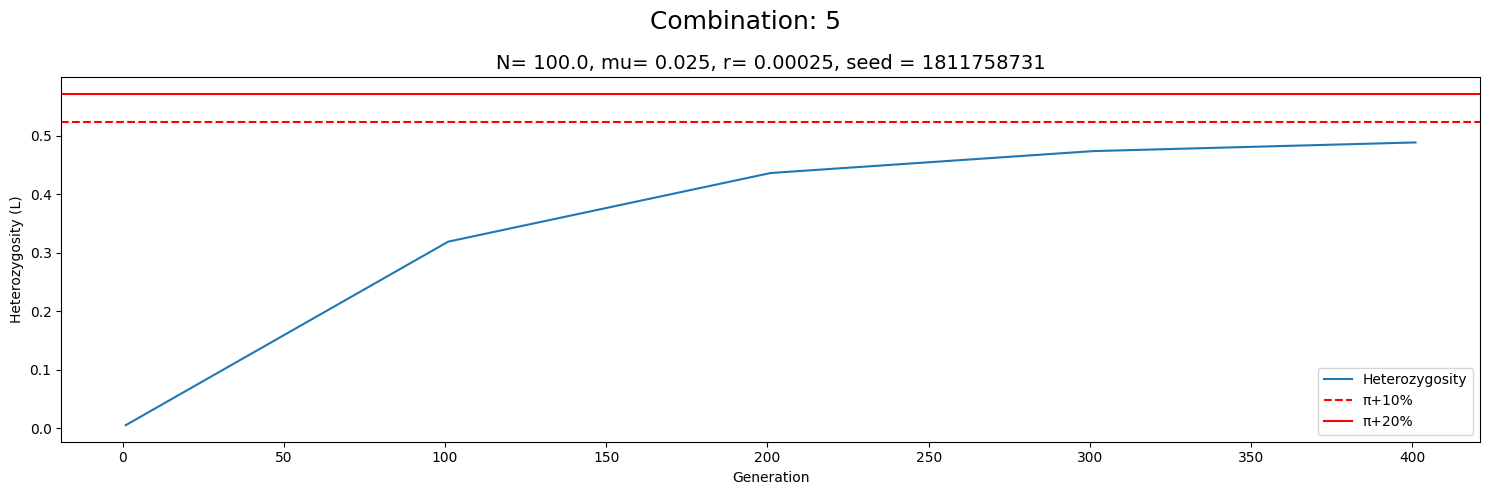

baseline:0.523809524
upperlimit:0.571428571
   cycle  Heterozygosity
0      1        0.004972
1    101        0.317126
2    201        0.433575
3    301        0.469379
4    401        0.489560


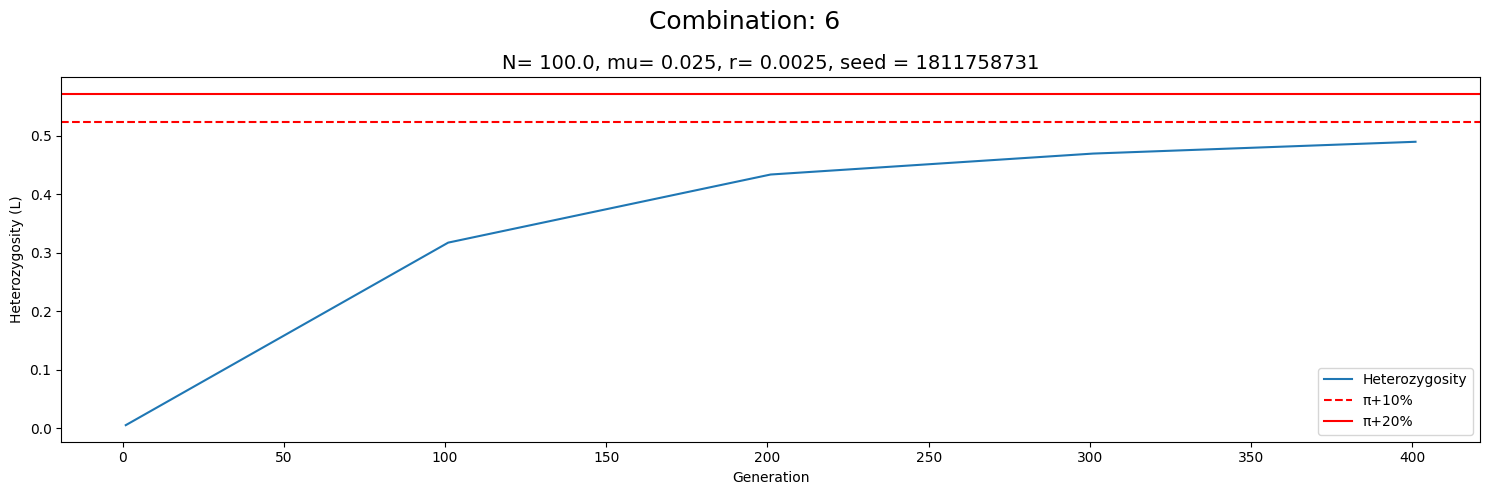

baseline:0.523809524
upperlimit:0.571428571
   cycle  Heterozygosity
0      1        0.049338
1    101        0.906612
2    201        0.908815
3    301        0.915594
4    401        0.896719


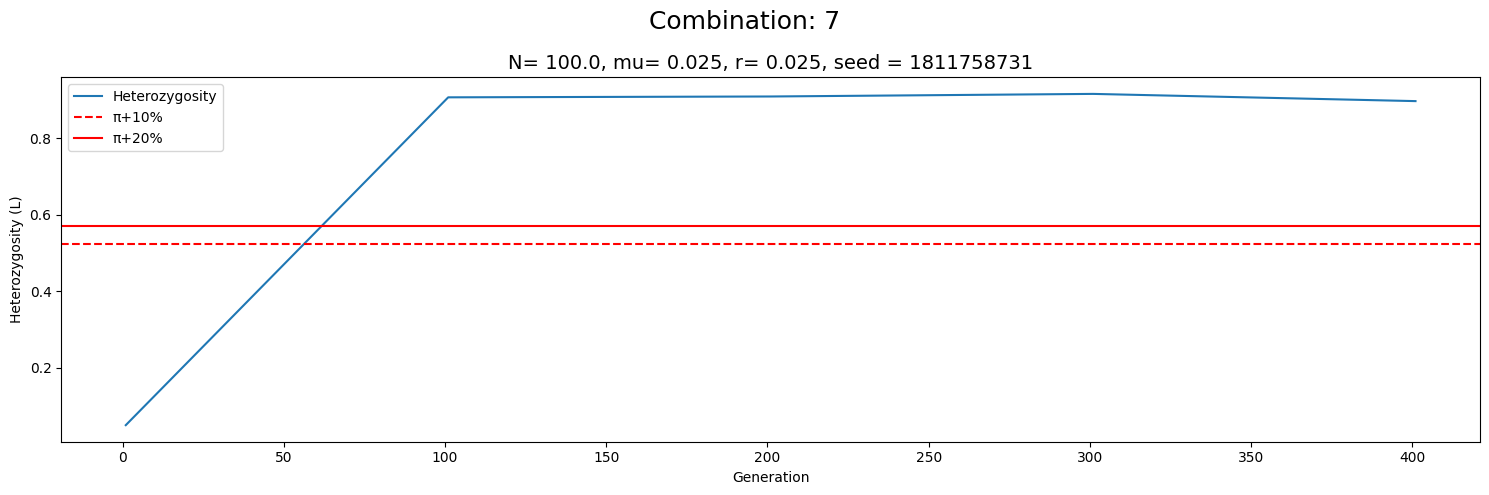

baseline:0.091666667
upperlimit:0.1
   cycle  Heterozygosity
0      1        0.049377
1    101        0.907736
2    201        0.910610
3    301        0.914110
4    401        0.917655


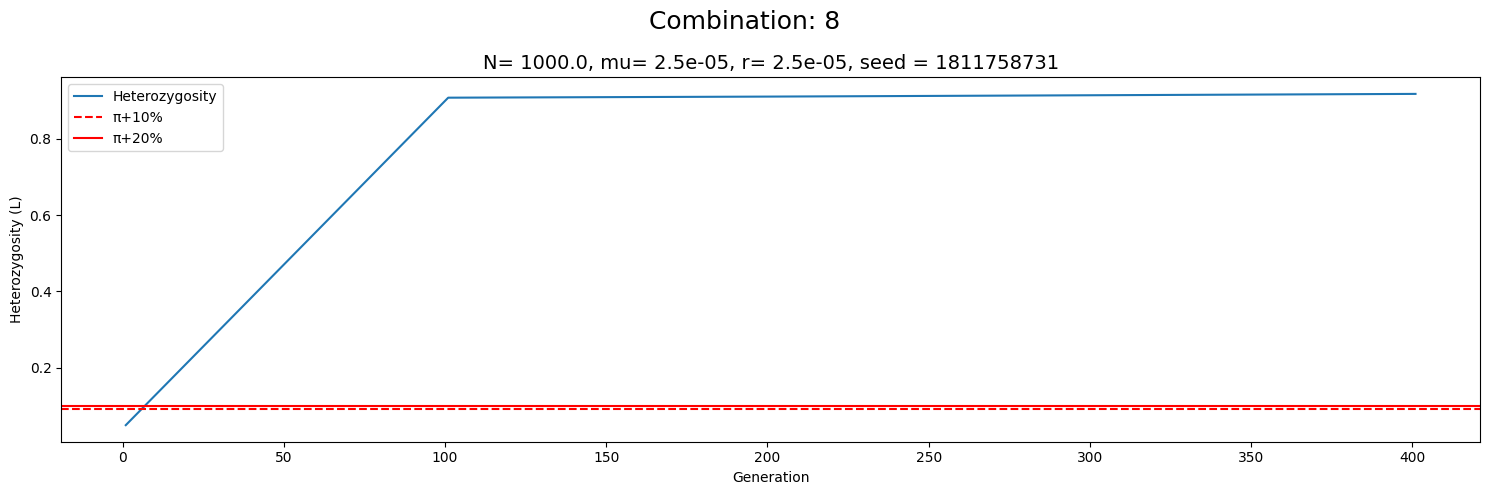

baseline:0.091666667
upperlimit:0.1
   cycle  Heterozygosity
0      1        0.049384
1    101        0.917284
2    201        0.909120
3    301        0.911918
4    401        0.909903


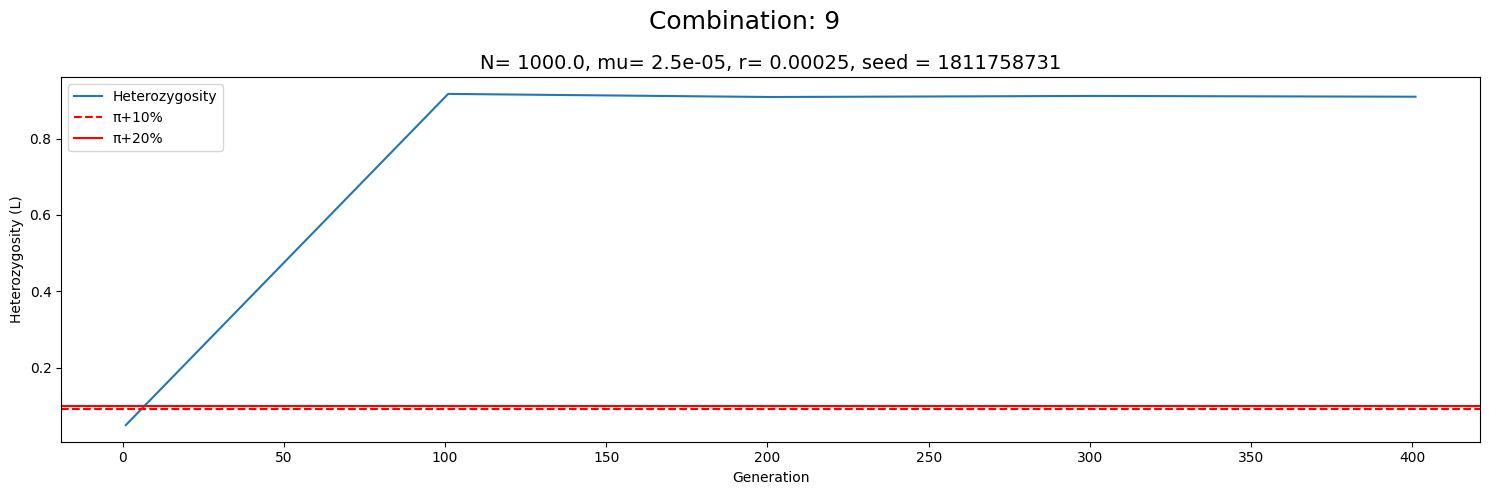

baseline:0.091666667
upperlimit:0.1
    cycle  Heterozygosity
0       1        0.000050
1     101        0.004999
2     201        0.009713
3     301        0.014043
4     401        0.018214
..    ...             ...
89   8901        0.090966
90   9001        0.091009
91   9101        0.091310
92   9201        0.091655
93   9301        0.091989

[94 rows x 2 columns]


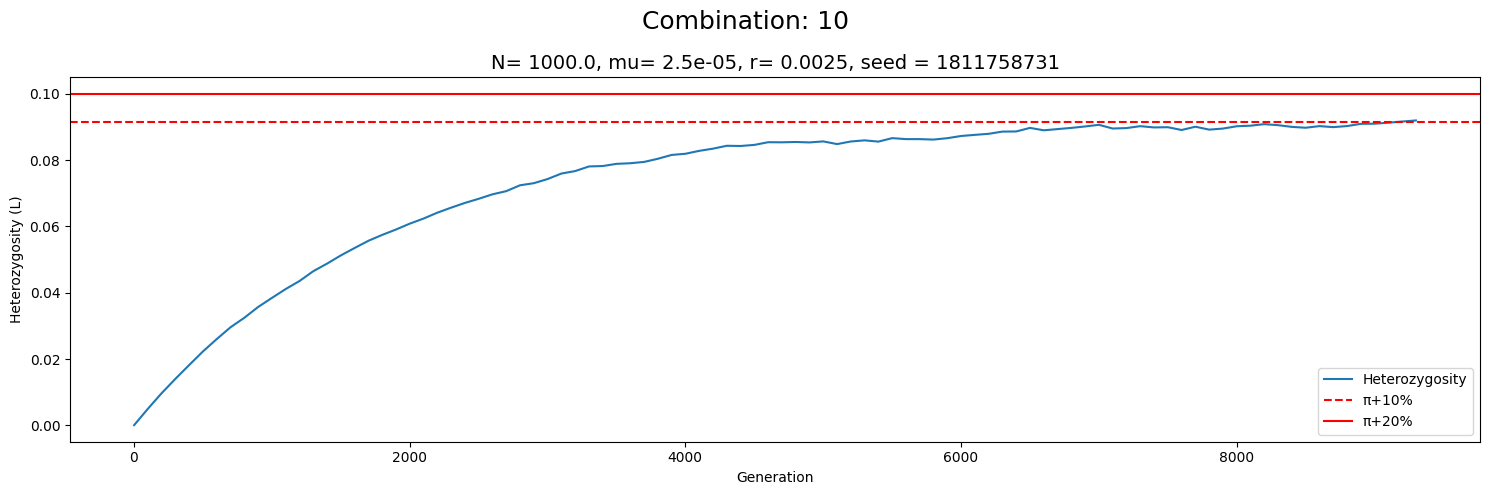

baseline:0.366666667
upperlimit:0.4


FileNotFoundError: [Errno 2] No such file or directory: 'burnin11_logfile.csv'

In [26]:
seed = 1811758731
plot_burnin(seed)

Plot nucleotide diversity AND Allele freq over time from the simulation logfiles

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys 

def check_Nuc_Diversity():
    '''
    This function plots the heterozygosity from each simulation against tick time and prints the number of ticks for checking.
    
    Arguments:
        array_index : combination number of this simulation (1-27)
        seed: seed number of simulation
        
    Returns:
        figure: plot of heterozygosity against tick with baseline and upperlimit for reference
        

    ''' 
    #plot size etc
    plt.rcParams["figure.figsize"] = [7.5, 5]
    plt.rcParams["figure.autolayout"] = True

    # read in csv of parameter combinations and nucleotide diversity
    parameters = pd.read_csv('C:/CHEYANNE STUFF/ICL Biology/Year 3/Final year project/Estimating-effective-population-size-from-resistance-loci/simulations/parameter_combinations.csv')

    #seeds
    #seeds = [1811758731, 2505954171, 1491780403, 963754032, 786513423, 2964823506, 1099540918, 3416744924, 2064465991, 3746829939]
    #for seed in seeds: 
    for array_index in range(1, 28): 
        index = array_index + 1
        #baseline and upperlimit
        baseline = parameters.iloc[index]['baseline']
        upperlimit = parameters.iloc[index]['upperlimit']
        print("baseline:" + str(baseline))
        print("upperlimit:"+ str(upperlimit))
        #parameters
        N = parameters.iloc[index]['N']
        mu = parameters.iloc[index]['Mutation Rate']
        r = parameters.iloc[index]['Recombination Rate']
        subtitle = "N= "+ str(N)+", mu= "+ str(mu)+ ", r= " + str(r)

        # read in logfile.csv (interval=100ticks) 
        logfile_path = str(array_index) + "_" + str(seed) + ".csv"
        df = pd.read_csv(logfile_path)
        print(df) #debug point

        # initial plot to check data is okay using heterozygosity
        figure = plt.figure(1)
        plt.plot('cycle','Heterozygosity', data = df, figure=figure)
        plt.axhline(y=baseline, color='r', linestyle='-', figure=figure) #10% of nucleotide diversity for reference
        plt.axhline(y=upperlimit, color='r', linestyle='-', figure=figure) #20% of nuc diversity for reference
        plt.xlabel('Generation', figure=figure)
        plt.ylabel('Nucleotide diversity (L)', figure=figure)
        plt.suptitle('Nucleotide diversity over generation time', figure=figure, fontsize =18)
        plt.title(subtitle, fontsize=14)
        

        # plot allele freq
        allelefreq_figure = plt.figure(2)
        plt.plot('cycle','Allele Frequency', data = df, figure=allelefreq_figure)
        plt.xlabel('Generation', figure=allelefreq_figure)
        plt.ylabel('Allele Frequency', figure=allelefreq_figure)
        plt.suptitle('Allele Frequency over generation time', figure=allelefreq_figure, fontsize =18)
        plt.title(subtitle, fontsize=14)

        #plt.show()
    return figure, allelefreq_figure


baseline:0.091666667
upperlimit:0.1
   Array Index      SeedID  cycle  Allele Frequency  Heterozygosity  \
0            1  1811758731   1100             0.005          0.0925   

   No_lineages  
0            0  
baseline:0.366666667
upperlimit:0.4


FileNotFoundError: [Errno 2] No such file or directory: '2_1811758731.csv'

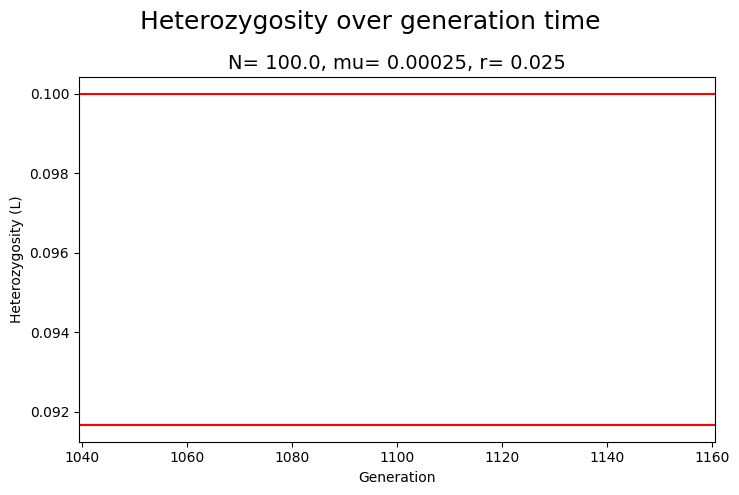

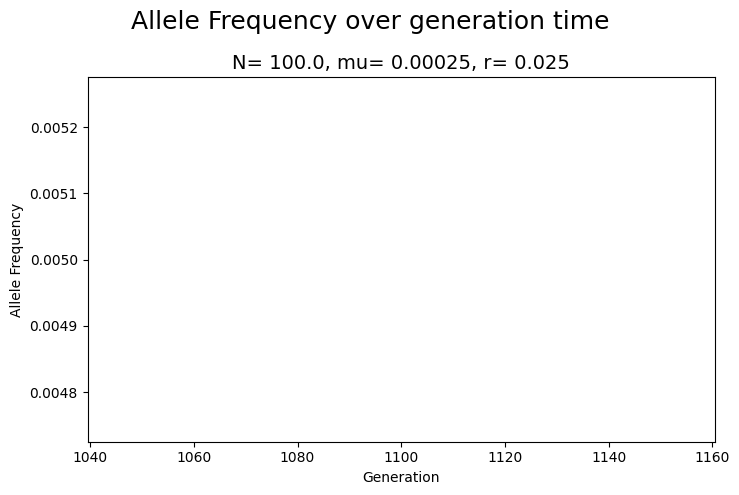

In [39]:
#test function on a simulation logfile
#global array_index 
#array_index = sys.argv[1]

#tested on 24, which is actually a burnin logfile just renamed
# tested on 1 which is a simulation logfile (correct) but terminated after 1 tick (bad)
check_Nuc_Diversity()
